# Projekt Zespołowy - ZMUM
## Analiza popularności muzyki na podstawie jej cech

**Autorzy**:  
>Michał Kiełczykowski 284240   
>Edward Sucharda 284388  
>Mateusz Szczygielski 284266

### Analizowany zbiór
Jako dane wykorzystano zbiór utworów muzycznych, które można znaleźć na kanale Spotify. Muzyka jest pochodzi z okresu 1921-2020. Dane otrzymano ze strony https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks?select=data.csv

### Przygotowanie danych

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression

In [2]:
music = pd.read_csv('data.csv')
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 19 columns):
acousticness        174389 non-null float64
artists             174389 non-null object
danceability        174389 non-null float64
duration_ms         174389 non-null int64
energy              174389 non-null float64
explicit            174389 non-null int64
id                  174389 non-null object
instrumentalness    174389 non-null float64
key                 174389 non-null int64
liveness            174389 non-null float64
loudness            174389 non-null float64
mode                174389 non-null int64
name                174389 non-null object
popularity          174389 non-null int64
release_date        174389 non-null object
speechiness         174389 non-null float64
tempo               174389 non-null float64
valence             174389 non-null float64
year                174389 non-null int64
dtypes: float64(9), int64(6), object(4)
memory usage: 25.3+ MB


#### Opis danych:  
| name        | descrpition |
|:-------------|:-------------------|
 acousticness: |  The relative metric of the track being acoustic <0, 1> 
artists: | The list of artists credited for production of the track  
danceability: | The relative measurement of the track being danceable <0,1>  
duration_ms: | The length of the track in milliseconds (ms)  
energy: | The energy of the track <0,1>  
explicit: | 0 = No explicit content, 1 = Explicit content  
id: | Id of track generated by Spotify  
instrumentalness: | The relative ratio of the track being instrumental <0,1>  
key: | All keys on octave encoded as values ranging from 0 to 11, starting on C as 0, C# as 1 and so on…  
loudness: | Relative loudness of the track in the typical range <-60, 0> in decibel (dB)  
mode: | The binary value representing whether the track starts with a major (1) chord progression or not (0)  
name: | The title of the track  
popularity: | The popularity of the song lately, default country = US, <0,100>  
release_date: | Date of release mostly in yyyy-mm-dd format, however precision of date may vary  
speechiness: | The relative length of the track containing any kind of human voice  
tempo: | The tempo of the track in Beat Per Minute (BPM)  
valence: | The relative duration of the track sounding as a live performance, <0,1>  
year: | The release year of track

Sprawdzenie czy można pozbyć się kolumny *year*, która zawiera w sobie informacje z kolumny *release_date*

In [3]:
music['str_year'] = music['year'].apply(lambda x: str(x))
no_exact_realaese_date = np.where(music['str_year'] == music['release_date'], 1, 0)
print("Liczba danych:", no_exact_realaese_date.sum())

Liczba danych: 50819


In [4]:
music['release_date'].head(10)

0          1920
1    1920-01-05
2          1920
3    1920-01-01
4    1920-10-01
5          1920
6          1920
7          1920
8    1920-07-08
9    1920-01-01
Name: release_date, dtype: object

Lepiej pozbyć się kolumny *release_date*, gdyż zbyt dużo danych ma niedokładną datę (tylko sam rok). Przy okazaji można się pozbyć *id* i *str_year* które nie wnoszą nowych informacji oraz *name* i *artist*, które nie sposób sensowanie zakodować liczbowo.

In [5]:
music = music.drop(['id', 'name', 'artists', 'str_year', 'release_date'], axis = 1)

In [6]:
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 15 columns):
acousticness        174389 non-null float64
danceability        174389 non-null float64
duration_ms         174389 non-null int64
energy              174389 non-null float64
explicit            174389 non-null int64
instrumentalness    174389 non-null float64
key                 174389 non-null int64
liveness            174389 non-null float64
loudness            174389 non-null float64
mode                174389 non-null int64
popularity          174389 non-null int64
speechiness         174389 non-null float64
tempo               174389 non-null float64
valence             174389 non-null float64
year                174389 non-null int64
dtypes: float64(9), int64(6)
memory usage: 20.0 MB


In [7]:
properties = music.describe()
properties.loc['skewness'] = music.skew()
properties.loc['median'] = music.median()
properties.loc['mode'] = music.mode().iloc[0]
properties.loc['variance'] = music.var()
properties.loc['kurtosis'] = music.kurtosis()

In [8]:
properties

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,174389.000000,174389.000000,1.743890e+05,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000
mean,0.499228,0.536758,2.328100e+05,0.482721,0.068135,0.197252,5.205305,0.211123,-11.750865,0.702384,25.693381,0.105729,117.006500,0.524533,1977.061764
std,0.379936,0.176025,1.483958e+05,0.272685,0.251978,0.334574,3.518292,0.180493,5.691591,0.457211,21.872740,0.182260,30.254178,0.264477,26.907950
min,0.000000,0.000000,4.937000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1920.000000
25%,0.087700,0.414000,1.661330e+05,0.249000,0.000000,0.000000,2.000000,0.099200,-14.908000,0.000000,1.000000,0.035200,93.931000,0.311000,1955.000000
50%,0.517000,0.548000,2.057870e+05,0.465000,0.000000,0.000524,5.000000,0.138000,-10.836000,1.000000,25.000000,0.045500,115.816000,0.536000,1977.000000
75%,0.895000,0.669000,2.657200e+05,0.711000,0.000000,0.252000,8.000000,0.270000,-7.499000,1.000000,42.000000,0.076300,135.011000,0.743000,1999.000000
max,0.996000,0.988000,5.338302e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.971000,243.507000,1.000000,2021.000000
skewness,-0.034518,-0.236234,1.015938e+01,0.144279,3.427836,1.363704,0.003932,2.078374,-0.989120,-0.885307,0.362937,3.750971,0.423394,-0.100729,-0.080966
median,0.517000,0.548000,2.057870e+05,0.465000,0.000000,0.000524,5.000000,0.138000,-10.836000,1.000000,25.000000,0.045500,115.816000,0.536000,1977.000000


#### Reprezentacja wizualna danych

Histogramy zmiennych

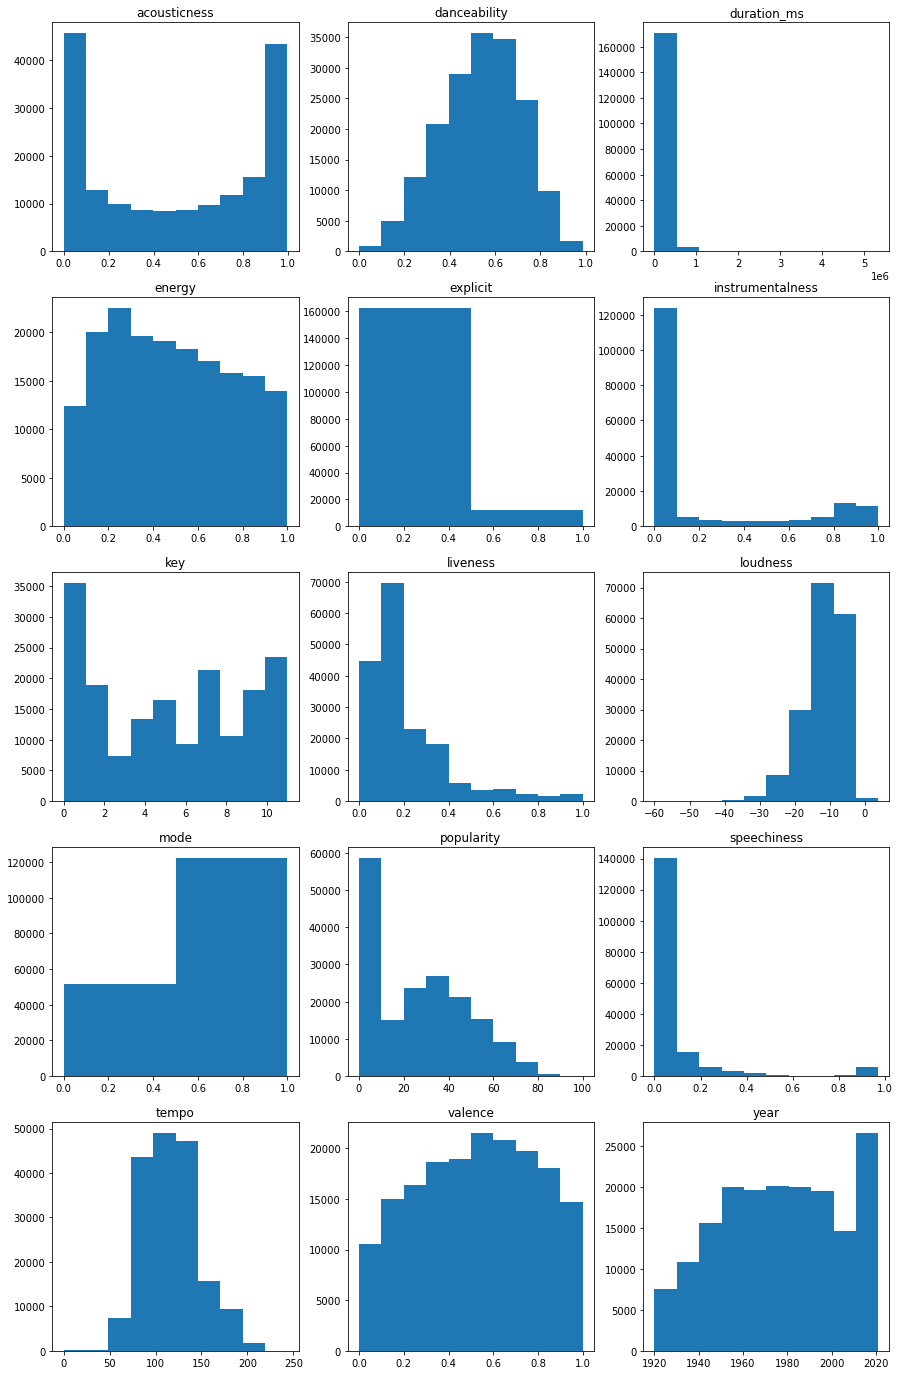

In [9]:
plt.figure(figsize=(15,5*len(music.columns.values)))
for i, column in enumerate(music):
    plt.subplot(len(music.columns.values), 3, i+1)
    plt.title(column)
    plt.hist(music[column], bins = min(len(music[column].unique()), 10))

Po analizie histogramów usuwamy dane odstające czyli te dla których *loudness* < -40 oraz te gdzie *duration_ms* > 2000000

In [10]:
music = music.drop(music[(music['duration_ms'] > 2000000) | (music['loudness'] < -40)].index, axis = 0)

Liczba próbek po usunięciu:

In [11]:
music.shape[0]

174158

Po usunięciu 231 próbek pozostało nadal 174158 próbek, czyli wystarczająco aby uzyskać wiarygodne wyniki estymacji.

Wygląd histogramów po usunięciu danych odstających

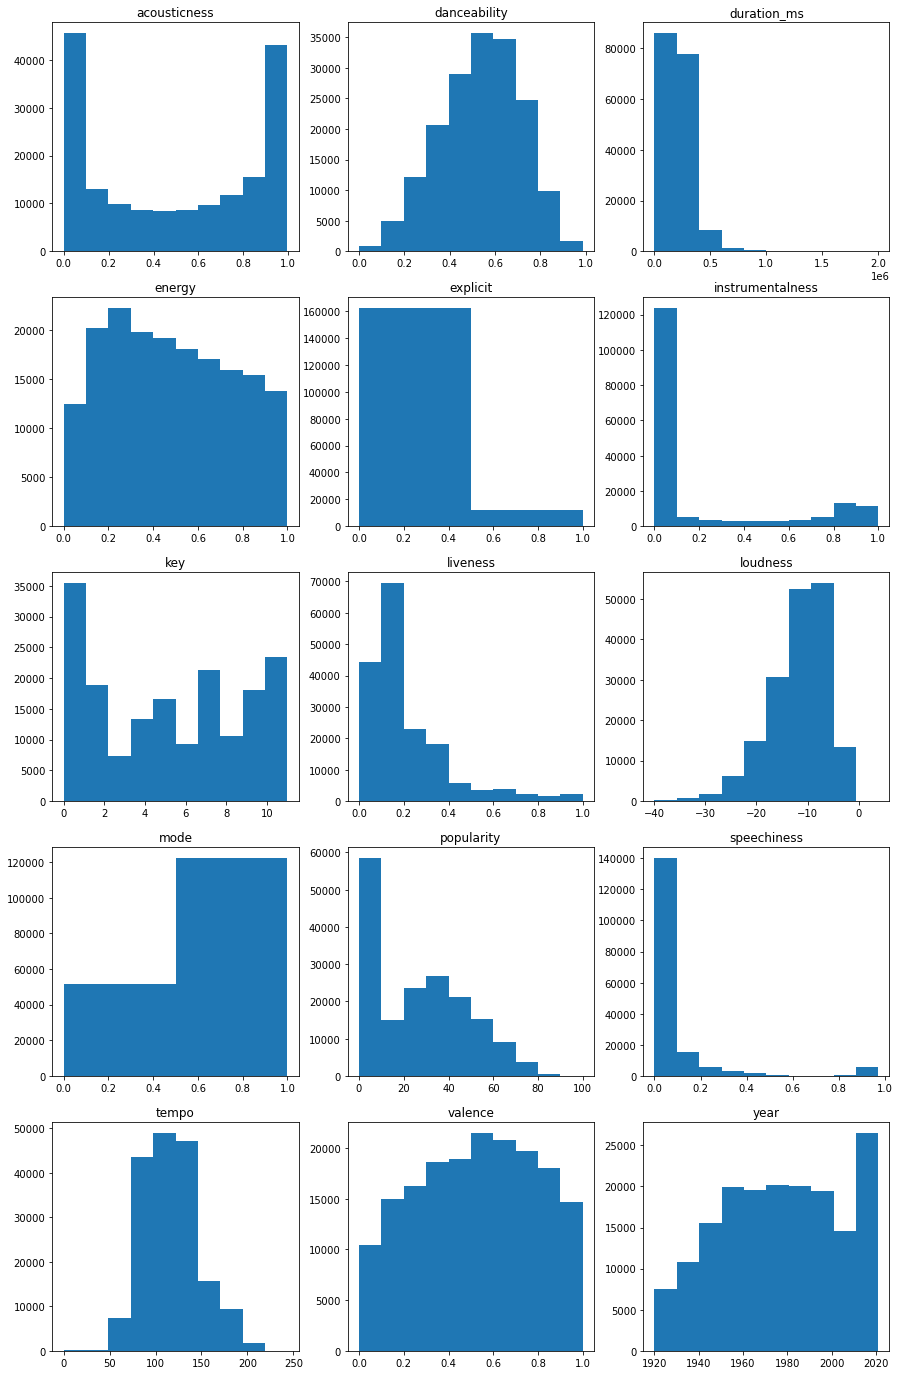

In [12]:
plt.figure(figsize=(15,5*len(music.columns.values)))
for i, column in enumerate(music):
    plt.subplot(len(music.columns.values), 3, i+1)
    plt.title(column)
    plt.hist(music[column], bins = min(len(music[column].unique()), 10))

#### Analiza korelacji zmiennych

Wyliczenie macierzy korelacji

<AxesSubplot:>

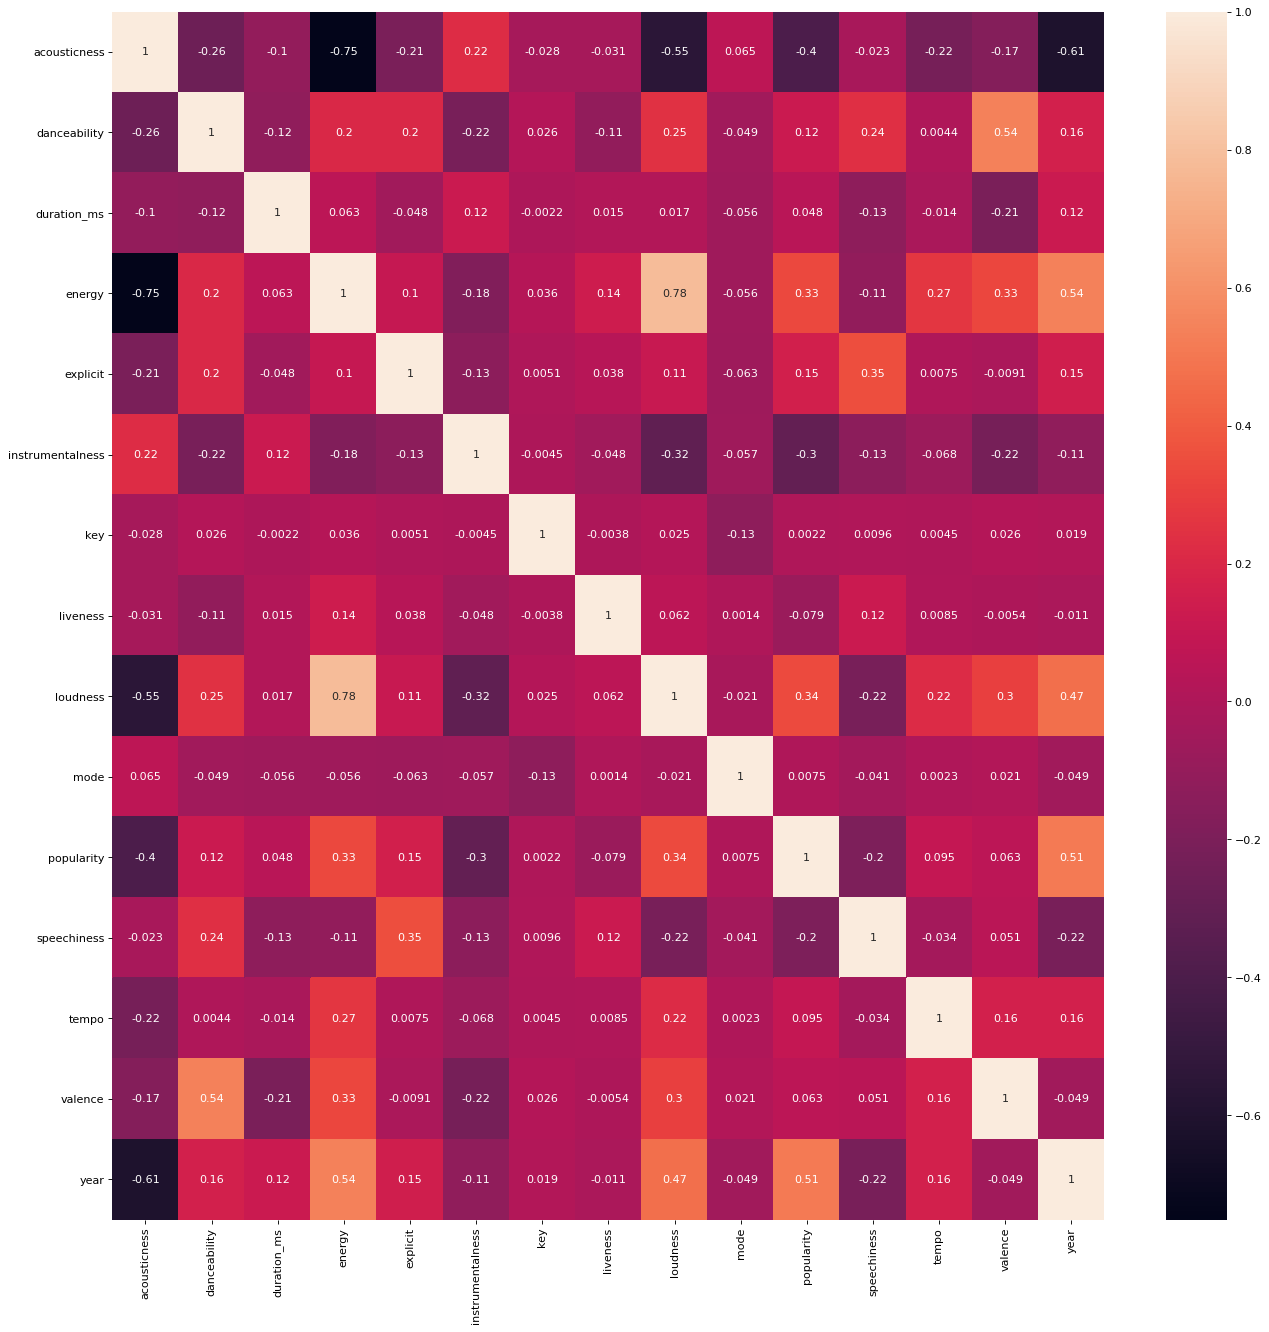

In [13]:
plt.figure(figsize=(20,20), dpi = 80)
corelation_matrix = music.corr()
sn.heatmap(corelation_matrix ,annot = music.corr())

Wzajemna korelacja cech wejściowych:

In [14]:
print("Cecha 1\tCecha 2\tWspółczynnik korelacji\n")
for index, row in corelation_matrix.iterrows():
    for (columnName, columnData) in corelation_matrix.iteritems():
        if index != columnName:
            if abs(columnData[index]) >= 0.5:
                print(columnName, index, abs(columnData[index]))

Cecha 1	Cecha 2	Współczynnik korelacji

energy acousticness 0.750984991608844
loudness acousticness 0.5492994262301822
year acousticness 0.6077160887667106
valence danceability 0.5360085738329868
acousticness energy 0.750984991608844
loudness energy 0.7815716957550926
year energy 0.5410512961204472
acousticness loudness 0.5492994262301822
energy loudness 0.7815716957550926
year popularity 0.5140617929650017
danceability valence 0.5360085738329868
acousticness year 0.6077160887667106
energy year 0.5410512961204472
popularity year 0.5140617929650017


Najwięcej cech skorelowanych mają *acousticness*, *year*, i *energy*. Postanowiono zbadać wyniki prostej regresji wielorakiej z dotychczaowych cech, żeby sprawdzić badanie, której wielkości ma największy sens.

Poniżej funckja wynaczająca błąd na danych treningowych i testowych, dla parametru estymowanego jako argument funkcji. 

In [15]:
def conut_error(estimated_feature):
    all_features_data = music.drop([estimated_feature], axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(all_features_data, music[estimated_feature], test_size=0.33, random_state=1)
    X_pinv = np.linalg.pinv(X_train)
    ω = np.dot(X_pinv, y_train)
    y_pred_train = np.dot(X_train, ω)
    train_error = mean_squared_error(y_train, y_pred_train, squared=False)
    y_pred_test = np.dot(X_test, ω)
    test_error = mean_squared_error(y_test, y_pred_test, squared=False)
    print('Train error: ' + str(train_error), ", Test error: " + str(test_error))

In [16]:
conut_error('energy')

Train error: 0.12138821084671461 , Test error: 0.12047871592424818


In [17]:
conut_error('year')

Train error: 182.48626810512988 , Test error: 182.10930323941346


In [18]:
conut_error('acousticness')

Train error: 0.22864406785491695 , Test error: 0.2272822728280594


Rozkład cechy *year* zawiera się w przedziale <1920, 2020>. Biorąc pod uwagę fakt, że pozostałe, analizowane cechy są znormalizowane do przedziału <0,1> oraz ich wartość błędu jest proporcjonalnie mniejsza, cecha energy została wybrana jako główny obszar analizy problemu badawczego. Na podstawie tej analizy postawiono następującą **hipotezę badawczą**:

### *H0: Istnieje możliwość szacowania energii muzyki na podstawie jej cech.*

cechy najbardziej skolerowane z *energy* to:

In [19]:
corelated_features = []
for index, row in corelation_matrix.iterrows():
    if abs(row['energy']) > 0.5 and index != 'energy':
        corelated_features.append(index)
print(corelated_features)

['acousticness', 'loudness', 'year']


Zbadano także cechy inne niż *energy*, które są skorelowane między sobą.

In [20]:
for index, row in corelation_matrix.iterrows():
    for (columnName, columnData) in corelation_matrix.iteritems():
        if index != 'energy' and columnName != 'energy' and index != columnName:
            if abs(columnData[index]) >= 0.5:
                print(columnName, index, abs(columnData[index]))

loudness acousticness 0.5492994262301822
year acousticness 0.6077160887667106
valence danceability 0.5360085738329868
acousticness loudness 0.5492994262301822
year popularity 0.5140617929650017
danceability valence 0.5360085738329868
acousticness year 0.6077160887667106
popularity year 0.5140617929650017


### Wnioski wynikające z analizy danych:
* próbek jest dużo więcej niż cech, więc da się jednoznacznie wyznaczyć najlepsze dopasowanie dla wszystkich cech
* występują cechy skorelowane z wyjściem co sugeruje, że istnieje potencjał badawczy wyznaczania zależności między cechami a energią
* niektóre cechy są skorelowane ze sobą i prawdopodobnie dobrze byłoby, którąś z każdej pary odrzucić albo wykorzystać do wytworzenia nowej cechy
* najbardziej skorelowane cechy z energią to kandydaci dla których współczynniki regresji linowej będą największe

## Tworzenie nowych cech

Na podstawie zauważonych prawych skośności dla cech:
* *instrumentalness*
* *liveness*
* *speechiness*  

Stworzono nowe cechy, w których jest ona niwelowana.

In [21]:
old_features = ['instrumentalness', 'liveness', 'speechiness']
new_features = ['log_instrumentalness', 'log_liveness', 'log_speechiness']
music['log_instrumentalness'] = music['instrumentalness'].apply(lambda x: np.log(x+1))
music['log_liveness'] = music['liveness'].apply(lambda x: np.log(x+1))
music['log_speechiness'] = music['speechiness'].apply(lambda x: np.log(x+1))

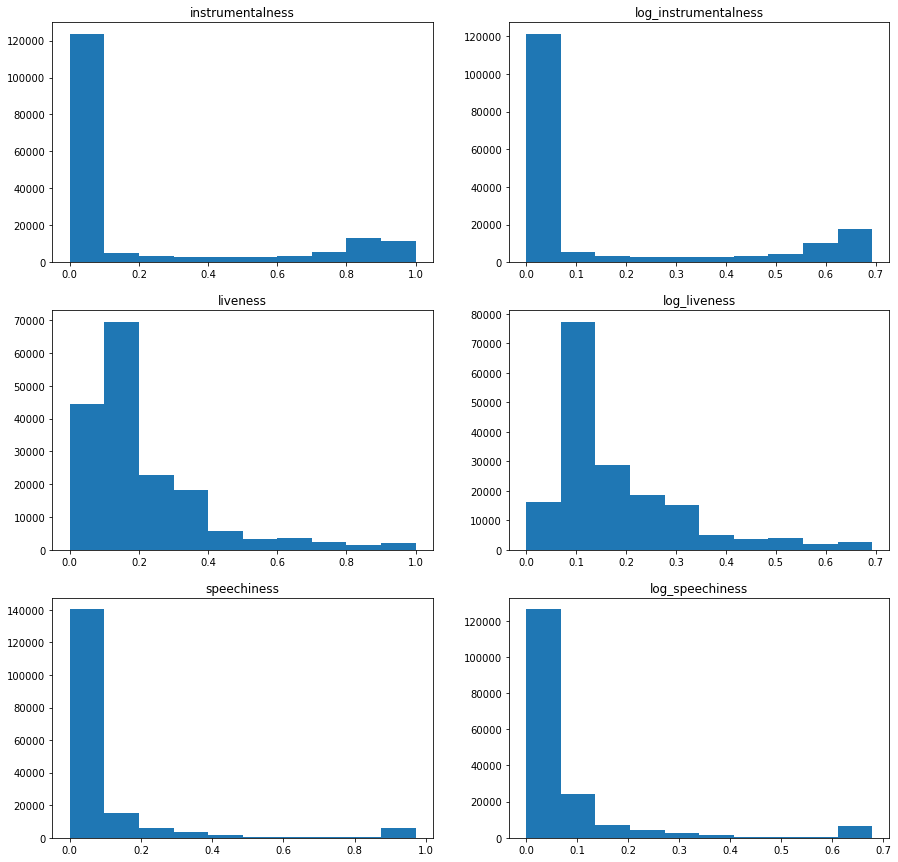

In [22]:
plt.figure(figsize=(15,5*len(old_features)))
for i, column in enumerate(old_features):
    plt.subplot(len(old_features), 2, 2*i+1)
    plt.title(old_features[i])
    plt.hist(music[old_features[i]], bins = min(len(music[old_features[i]].unique()), 10))
    
    plt.subplot(len(old_features), 2, 2*i+2)
    plt.title(new_features[i])
    plt.hist(music[new_features[i]], bins = min(len(music[new_features[i]].unique()), 10))

In [23]:
for i, column in enumerate(old_features):
    print("{} - skew: {}".format(old_features[i], music[old_features[i]].skew()))
    print("{} - skew: {}".format(new_features[i], music[new_features[i]].skew()))
    print("---")

instrumentalness - skew: 1.3663733881603026
log_instrumentalness - skew: 1.2838020326226074
---
liveness - skew: 2.078289393315535
log_liveness - skew: 1.6900634833126753
---
speechiness - skew: 3.7511785353004603
log_speechiness - skew: 3.4047836019198865
---


Nowe cechy poprawiły prawoskośność oryginalnych cech

Próbowano też różnych kombinacji cech, które są choć trochę skorelowane

In [24]:
corelated_features = []
for index, row in corelation_matrix.iterrows():
    if abs(row['energy']) > 0.3 and index != 'energy':
        corelated_features.append(index)
print(corelated_features)

['acousticness', 'loudness', 'popularity', 'valence', 'year']


Ostatecznie wygenerowano szereg cech, na podstawie których wyznaczono macierz korelacji nowych cech z wyjściem

In [25]:
features = music.drop(['energy'], axis = 1)
basic_features = features.columns.values
corelated_features2 = []
for name in corelated_features:
    music['cube_'+ name] = music[name].apply(lambda x: x ** 3)
    music['square_'+ name] = music[name].apply(lambda x: x ** 2)
    new_features.append('cube_'+ name)
    new_features.append('square_'+ name)
    for element in corelated_features2:
        music[name + '_times_' + element] = music[name]*music[element]
        new_features.append(name + '_times_' + element)
    corelated_features2.append(name)

<AxesSubplot:>

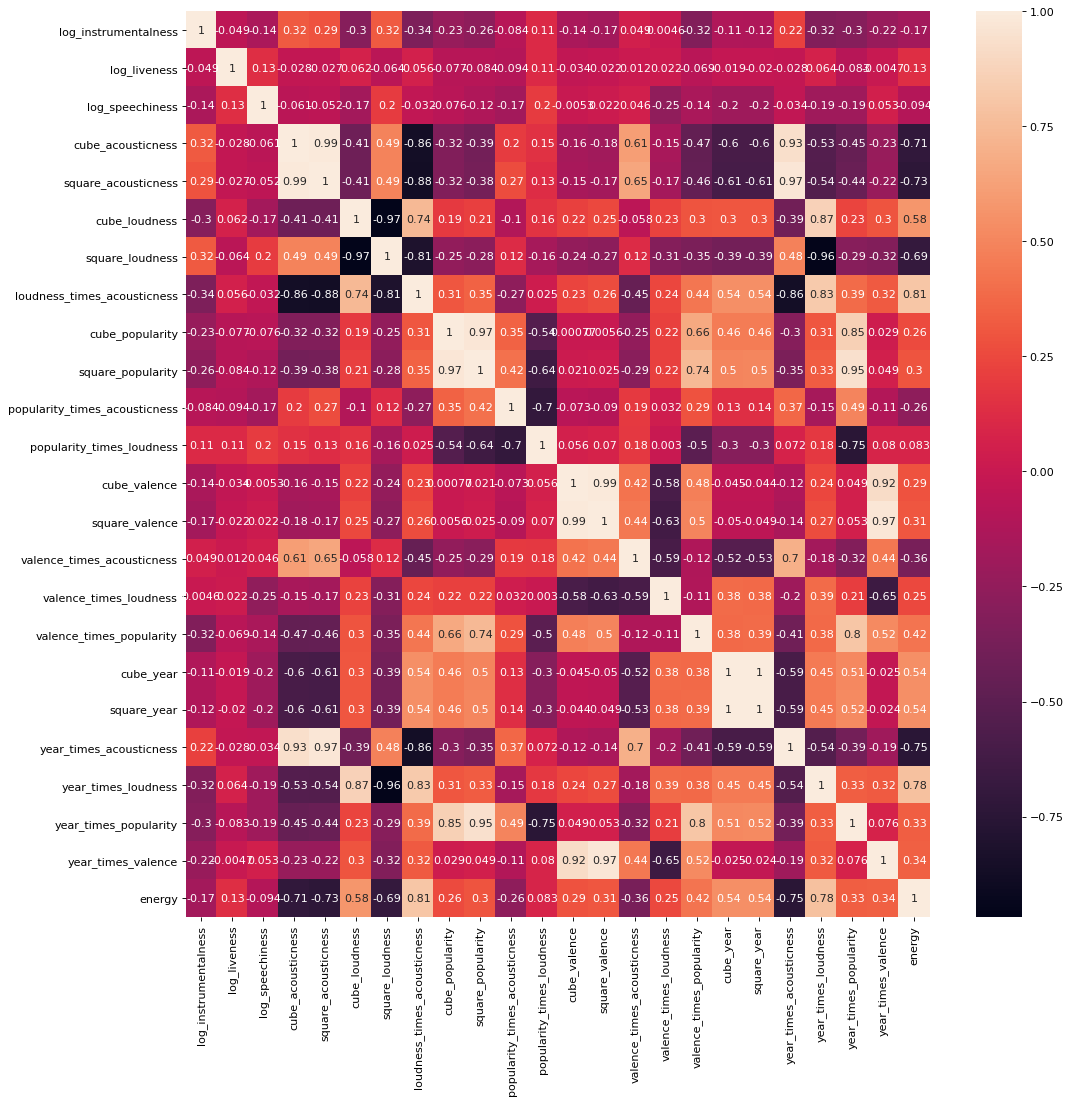

In [26]:
new_features_plus_output = new_features.copy()
new_features_plus_output.append('energy')
new_features_data = music[new_features_plus_output]
plt.figure(figsize=(15,15), dpi = 80)
sn.heatmap(new_features_data.corr(), annot = new_features_data.corr())

In [27]:
# połączenie nowych cech ze starymi
music.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,...,square_valence,valence_times_acousticness,valence_times_loudness,valence_times_popularity,cube_year,square_year,year_times_acousticness,year_times_loudness,year_times_popularity,year_times_valence
0,0.991000,0.598,168333,0.224,0,0.000522,5,0.3790,-12.628,0,...,0.401956,0.628294,-8.006152,7.6080,7077888000,3686400,1902.72000,-24245.76,23040,1217.280
1,0.643000,0.852,150200,0.517,0,0.026400,5,0.0809,-7.261,0,...,0.902500,0.610850,-6.897950,6.6500,7077888000,3686400,1234.56000,-13941.12,13440,1824.000
2,0.993000,0.647,163827,0.186,0,0.000018,0,0.5190,-12.098,1,...,0.474721,0.684177,-8.335522,2.7560,7077888000,3686400,1906.56000,-23228.16,7680,1322.880
3,0.000173,0.730,422087,0.798,0,0.801000,2,0.1280,-7.311,1,...,0.001781,0.000007,-0.308524,0.7174,7077888000,3686400,0.33216,-14037.12,32640,81.024
4,0.295000,0.704,165224,0.707,1,0.000246,10,0.4020,-6.036,0,...,0.089401,0.088205,-1.804764,0.5980,7077888000,3686400,566.40000,-11589.12,3840,574.080


W celu lepszej wizualizacji zależności pomiędzy cechami a rokiem wylosowano 5% próbek, które przedstawiono na wykresach z uwagi, że 100% populacji dawało nieczytelny obraz.

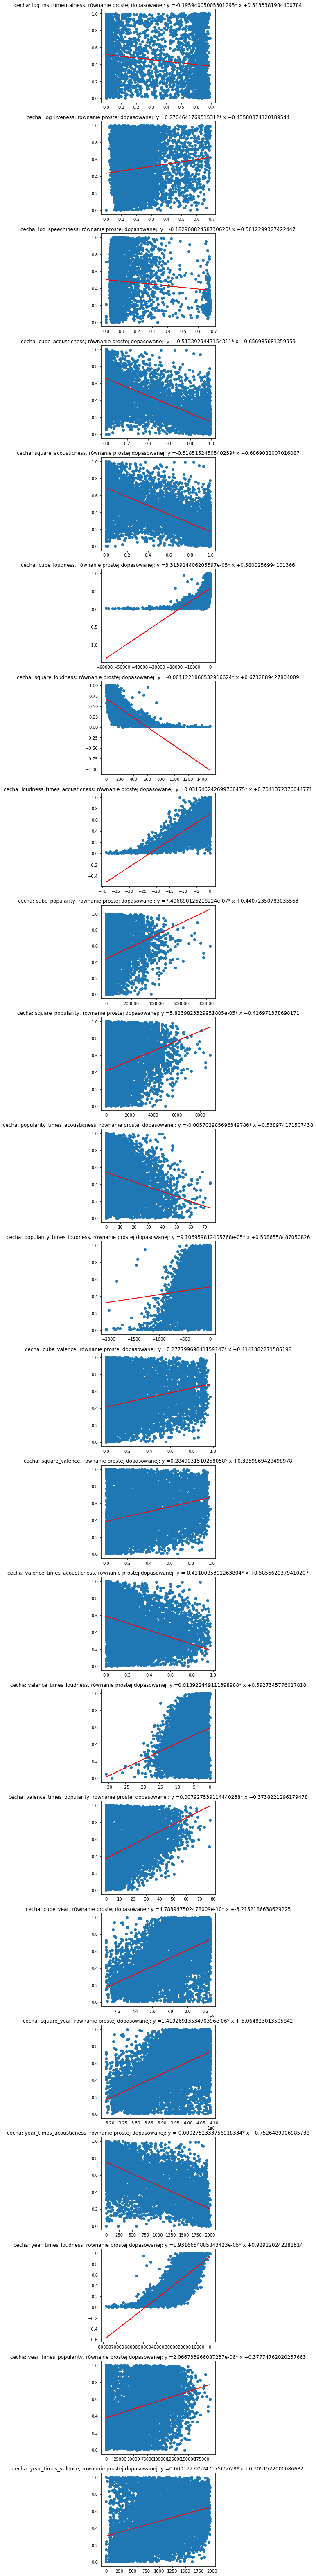

In [28]:
plt.figure(figsize=(5,5*len(new_features)))
all_features_data = music.drop(['energy'], axis = 1)
big_music_data, small_music_data, years_big, years_small = train_test_split(all_features_data, music['energy'], test_size=0.05, random_state=1)
for i, feature in enumerate(new_features):
    plt.subplot(len(new_features), 1, i+1)
    m,b = np.polyfit(small_music_data[feature], years_small,1)
    plt.title('cecha: ' + feature + '; równanie prostej dopasowanej: y =' + str(m) +'* x +' + str(b) )
    plt.plot(small_music_data[feature], m * small_music_data[feature] + b, color = 'red')
    plt.scatter(small_music_data[feature], years_small)

Na tej podstawie można wnioskować, że cecha *log_instrumentalness* i *year_times_valence* została nietrafnie stworzona i nie bedzie brała udziału w uczeniu, natomiast widać pewną relację liniową w cesze *year_times_acousticness* czy *square_acousticness*, które prawdopodobnie będą miały spory udział w uczeniu.

### Wybór cech modelu regresji

Poniższa sekcja przedstawia cechy wybrane przez różne automatyczne metody doboru cech.

Na początku jednak rozróżnione zostaną cechy wejściowe od wyjsciowych oraz zostanie podzielony zbiór na dane testowe i treningowe

In [29]:
output_feature = 'energy'
input_features = music.columns.tolist()
input_features.remove(output_feature)
X_train, X_test, y_train, y_test = train_test_split(music[input_features], music['energy'], test_size=0.33, random_state=1)

1. Metoda regularyzacji Lasso

/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 598.8383163898828, tolerance: 0.6953555084765376
  model = cd_fast.enet_coordinate_descent(
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. Y

/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 477.82677224651115, tolerance: 0.6925205916152158
  model = cd_fast.enet_coordinate_descent(
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.98676302775965, tolerance: 0.6910898155947773
  model = cd_fast.enet_coordinate_descent(
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 413.4368751180798, tolerance: 0.6953555084765376
  model = cd_fast.enet_coordinate_descent(
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/l

/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7353677691694429, tolerance: 0.6953555084765376
  model = cd_fast.enet_coordinate_descent(
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7136644589104435, tolerance: 0.6934745622428992
  model = cd_fast.enet_coordinate_descent(
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6922348909893117, tolerance: 0.6910898155947773
  model = cd_fast.enet_coordinate_descent(
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/

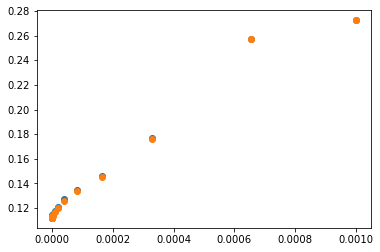

In [30]:
λ = [0.0, 0.00000001]
λ_treshold = 0.001
factor = 2.0
while λ[-1] * factor < λ_treshold:
    λ.append(λ[-1] * factor)
if λ[-1] != λ_treshold:
    λ.append(λ_treshold)

train_error = []
test_error = []

for item in λ:
    model = linear_model.Lasso(alpha=item, normalize=True)
    estimator = cross_validate(model, X_train[input_features], y_train, return_estimator=True)
    train_error.append(np.mean([mean_squared_error(y_train, estim.predict(X_train[input_features]), squared=False) for estim in estimator['estimator']]))
    test_error.append(np.mean([mean_squared_error(y_test, estim.predict(X_test[input_features]), squared=False) for estim in estimator['estimator']]))
plt.scatter(λ, train_error)
plt.scatter(λ, test_error)

Na podstawie powyższej analizy metoda Lasso wskazała, że do procesu nauki powinniśmy wykorzystać wszystkie zmienne.

2. Metoda Forward Stepwise

Wybrane cechy:  ['loudness_times_acousticness', 'loudness', 'acousticness', 'square_valence', 'liveness', 'log_instrumentalness', 'danceability', 'cube_loudness', 'valence_times_acousticness', 'cube_acousticness', 'square_acousticness', 'cube_popularity', 'valence_times_popularity', 'log_speechiness', 'speechiness', 'explicit', 'year', 'cube_year', 'square_year', 'square_popularity', 'mode', 'duration_ms', 'tempo', 'year_times_acousticness', 'log_liveness', 'instrumentalness', 'cube_valence', 'popularity_times_acousticness', 'year_times_popularity', 'popularity', 'square_loudness', 'year_times_loudness', 'key', 'valence_times_loudness']
Liczba cech:  34
Błąd uczenia:  0.1697084538276632
Błąd testowania:  0.16681647682940193


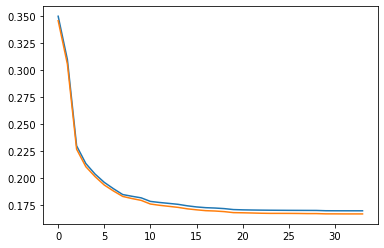

In [31]:
lr = LinearRegression()
errors_train = []
errors_test = []
features =  input_features.copy()
features_copy =  input_features.copy()
temp_features = []

for i in range(len(features)):
    temp_error = float("inf")
    if len(temp_features) != 0:
        temp_error = 1.0 - np.mean(cross_val_score(lr, X_train[temp_features].to_numpy(), y_train.to_numpy(), cv=5))
    temp_index = -1
    new_temp_error = float("inf") # błąd modelu z nową cechą
    for j, value in enumerate(features_copy):
        temp_features.append(value)
        error = 1.0 - np.mean(cross_val_score(lr, X_train[temp_features].to_numpy(), y_train.to_numpy(), cv=5))
        if(error < new_temp_error):
            temp_index = j
            new_temp_error = error
        del temp_features[-1]
    if new_temp_error < temp_error:
        temp_error = new_temp_error
        temp_features.append(features_copy[temp_index])
        del features_copy[temp_index]
        errors_train.append(1.0 - np.mean(cross_val_score(lr, X_train[temp_features].to_numpy(), y_train.to_numpy(), cv=5)))
        errors_test.append(1.0 - np.mean(cross_val_score(lr, X_test[temp_features].to_numpy(), y_test.to_numpy(), cv=5)))
    else:
        break
plt.plot(range(len(temp_features)), errors_train)
plt.plot(range(len(temp_features)), errors_test)
print("Wybrane cechy: ", temp_features)
print("Liczba cech: ", len(temp_features))
print("Błąd uczenia: ", 1.0 - np.mean(cross_val_score(lr, X_train[temp_features].to_numpy(), y_train.to_numpy(),cv=5)))
print("Błąd testowania: ", 1.0 - np.mean(cross_val_score(lr, X_test[temp_features].to_numpy(), y_test.to_numpy(), cv=5)))
      
forward_stepwise_features = temp_features.copy()

3. Metoda Backward Stepwise

In [32]:
lr = LinearRegression()
errors_train = []
errors_test = []
features =  input_features.copy()
features_copy =  input_features.copy()
temp_features = input_features.copy()

for i in range(len(features)):
    temp_error = float("inf")
    if len(temp_features) != 0:
        temp_error = 1.0 - np.mean(cross_val_score(lr, X_train[temp_features].to_numpy(), y_train.to_numpy(), cv=5))
    temp_index = -1
    new_temp_error = float("inf") # błąd modelu z nową cechą
    for j, value in enumerate(features_copy):
        temp_features.remove(value)
        error = 1.0 - np.mean(cross_val_score(lr, X_train[temp_features].to_numpy(), y_train.to_numpy(), cv=5))
        if(error < new_temp_error):
            temp_index = j
            new_temp_error = error
        temp_features.append(value)
    if new_temp_error < temp_error:
        temp_error = new_temp_error
        temp_features.remove(features_copy[temp_index])
        del features_copy[temp_index]
        errors_train.append(1.0 - np.mean(cross_val_score(lr, X_train[temp_features].to_numpy(), y_train.to_numpy(), cv=5)))
        errors_test.append(1.0 - np.mean(cross_val_score(lr, X_test[temp_features].to_numpy(), y_test.to_numpy(), cv=5)))
    else:
        break
print("Wybrane cechy: ", temp_features)
print("Liczba wybranych cech: ", len(temp_features))
print("Błąd uczenia: ", 1.0 - np.mean(cross_val_score(lr, X_train[temp_features].to_numpy(), y_train.to_numpy(), cv=5)))
print("Błąd testowania: ", 1.0 - np.mean(cross_val_score(lr, X_test[temp_features].to_numpy(), y_test.to_numpy(), cv=5)))

backward_stepwise_features = temp_features.copy()

Wybrane cechy:  ['danceability', 'duration_ms', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo', 'valence', 'year', 'log_instrumentalness', 'log_liveness', 'log_speechiness', 'cube_acousticness', 'square_acousticness', 'cube_loudness', 'square_loudness', 'loudness_times_acousticness', 'cube_popularity', 'square_popularity', 'cube_valence', 'valence_times_acousticness', 'valence_times_loudness', 'valence_times_popularity', 'cube_year', 'square_year', 'year_times_acousticness', 'year_times_loudness', 'year_times_popularity', 'year_times_valence']
Liczba wybranych cech:  33
Błąd uczenia:  0.16969279678113147
Błąd testowania:  0.1667180256037778


4. Metoda każdy z każdym

kolejne cechy:  ['acousticness', 'danceability', 'duration_ms', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo', 'valence', 'year', 'log_instrumentalness', 'log_liveness', 'log_speechiness', 'cube_acousticness', 'square_acousticness', 'cube_loudness', 'square_loudness', 'loudness_times_acousticness', 'cube_popularity', 'square_popularity', 'popularity_times_acousticness', 'popularity_times_loudness', 'cube_valence', 'square_valence', 'valence_times_acousticness', 'valence_times_loudness', 'valence_times_popularity', 'cube_year', 'square_year', 'year_times_acousticness', 'year_times_loudness', 'year_times_popularity', 'year_times_valence', 'mode', 'acousticness', 'year_times_acousticness', 'popularity', 'duration_ms', 'square_popularity', 'valence_times_loudness', 'liveness', 'log_instrumentalness', 'valence', 'explicit', 'square_valence', 'loudness', 'log_liveness', 'speechiness', 'valence_times_acousticness', 'cube_valence', 

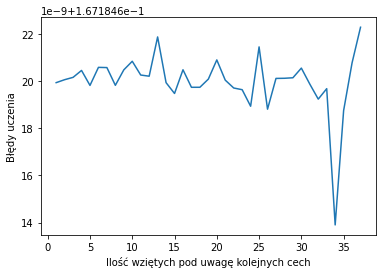

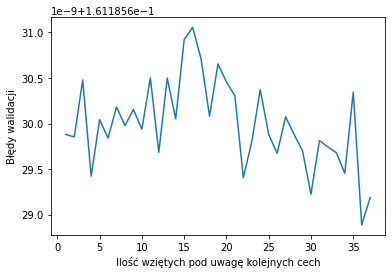

In [33]:
lr = LinearRegression()
errors_train = []
errors_test = []
features =  input_features.copy()
features_copy =  input_features.copy()
temp_features = input_features.copy()
brute_force_features = []
global_min_error = float("inf")



for i in range(len(features)):
    temp_error = float("inf")
    temp_index = -1
    for j, value in enumerate(features_copy):
        temp_features.append(value)
        error = 1.0 - np.mean(cross_val_score(lr, X_train[temp_features].to_numpy(), y_train.to_numpy(), cv=5))
        if(error < temp_error):
            if (error < global_min_error):
                global_min_error = error
                brute_force_features = temp_features.copy()
            temp_index = j
            temp_error = error
        del temp_features[-1]
    temp_features.append(features_copy[temp_index])
    del features_copy[temp_index]
    errors_train.append(1.0 - max(cross_val_score(lr, X_train[temp_features].to_numpy(), y_train.to_numpy(), cv=5)))
    errors_test.append(1.0 - max(cross_val_score(lr, X_test[temp_features].to_numpy(), y_test.to_numpy(), cv=5)))
plt.figure()
plt.ylabel("Błędy uczenia")
plt.plot(range(1, len(features)+1), errors_train)
plt.xlabel("Ilość wziętych pod uwagę kolejnych cech")

plt.figure()
plt.ylabel("Błędy walidacji")
plt.plot(range(1, len(features)+1), errors_test)
plt.xlabel("Ilość wziętych pod uwagę kolejnych cech")
print("kolejne cechy: ", temp_features)



Wnioski:
* widoczny jest fakt, że model wymaga dużej liczby cech do prawidłowego działania, na co wskazała każda automatyczna metoda doboru cech
* w porównaniu do liczby użytych próbek cech jest dużo mniej co może sprawić, że nie wykorzystamy w pełni potencjału tak dużego zbioru danych
* dodanie kolejnych cech sprawia, że wzmocnione zostaje wnioskowanie modelu regresji jednak brak dużej ilości dobrze skorelowanych z wyjściem cech nie pozwoli na osiągnięcie dobrego estymowania energii z niską wartością błędu

### Trenowanie modeli

Przygotowano metodę przy pomocy, której zostanie policzony błąd każdego modelu regresji wielorakiej

In [34]:
def measureModel(X_train, y_train, X_test, y_test):
    X_pinv = np.linalg.pinv(X_train)
    ω = np.dot(X_pinv, y_train)
    y_pred_train = np.dot(X_train, ω)
    train_error = mean_squared_error(y_train, y_pred_train, squared=False)
    y_pred_test = np.dot(X_test, ω)
    test_error = mean_squared_error(y_test, y_pred_test, squared=False)
    print('Train error: ' + str(train_error), ", Test error: " + str(test_error))
    return train_error, test_error

train_error = []
test_error = []

Model składający się ze wszystkich cech (Lasso)

In [35]:
tr_error, ts_error = measureModel(X_train, y_train, X_test, y_test)
train_error.append(tr_error)
test_error.append(ts_error)

Train error: 0.11265459359723615 , Test error: 0.11177414466264438


Model z cechami dobranymi metodą w przód

In [36]:
tr_error, ts_error  =  measureModel(X_train[forward_stepwise_features], y_train, X_test[forward_stepwise_features], y_test)
train_error.append(tr_error)
test_error.append(ts_error)

Train error: 0.11265636065044793 , Test error: 0.11178502630359291


Model z cechami dobranymi metodą w tył

In [37]:
tr_error, ts_error = measureModel(X_train[backward_stepwise_features], y_train, X_test[backward_stepwise_features], y_test)
train_error.append(tr_error)
test_error.append(ts_error)

Train error: 0.11265682675590974 , Test error: 0.11176918063325668


Model z cechami dobranymi metodą każdy z każdym

In [38]:
tr_error, ts_error = measureModel(X_train[brute_force_features], y_train, X_test[brute_force_features], y_test)
train_error.append(tr_error)
test_error.append(ts_error)

Train error: 0.11265459359796288 , Test error: 0.11177413912341817


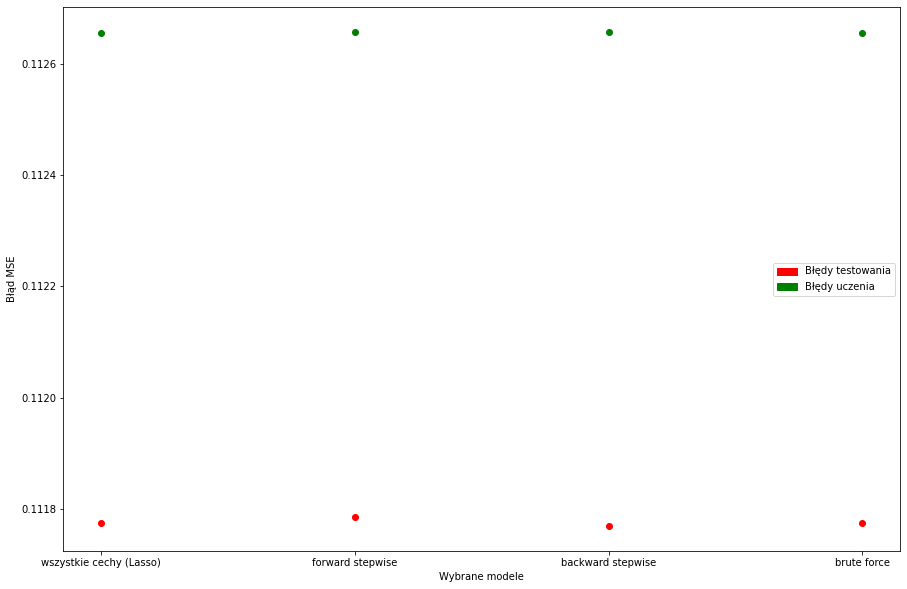

In [39]:
kolumny = [
    'wszystkie cechy (Lasso)',
    'forward stepwise',
    'backward stepwise',
    'brute force'
]


plt.figure(figsize=(15, 10))
for i, elem in enumerate(train_error):
    plt.ylabel("Błąd MSE")
    plt.xlabel("Wybrane modele")
    plt.scatter(kolumny[i], train_error[i], c = 'green')
    plt.scatter(kolumny[i], test_error[i], c = 'red')   


import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='red', label='Błędy testowania')
green_patch = mpatches.Patch(color='green', label='Błędy uczenia')

plt.legend(handles=[red_patch, green_patch])

Wnioski:
* Model regresji wielorakiej zwraca bardzo zbliożone wyniki dla każdego z wyznaczonych zestawu cech
* Błędy dla zbioru testowego są mniejsze niż w przypadku zbioru uczelnia. Pokazuje to, że model nie jest w stanie douczyć się do zadanego problemu. Wybrane cechy nie są dostatecznie dobrze skorelowane ze zmienną przewidywaną

## Regularyzacja dla najlepszego modelu

### Dobranie współczynnika regularyzacji dla metody grzbietowej

Zostają rozpatrzone współczynniki:
[0.0, 0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.024, 2.048, 4.096, 8.192, 16.384, 32.768]


/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.4534e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.44975e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.44493e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.45741e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-co

/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.1186e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.78337e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.78067e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.76806e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-co

/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.73166e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.52411e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.5264e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.50756e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/mkielczykowski/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-co

Najmniejszy błąd uczenia dla współczynnika regularyzacji:
0.0


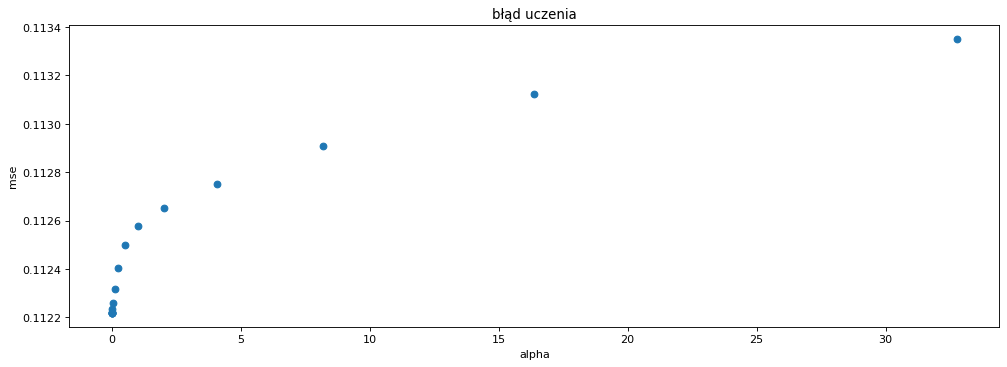

In [40]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

backward_stepwise_features = ['danceability', 'duration_ms', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo', 'valence', 'year', 'log_instrumentalness', 'log_liveness', 'log_speechiness', 'cube_acousticness', 'square_acousticness', 'cube_loudness', 'square_loudness', 'loudness_times_acousticness', 'cube_popularity', 'square_popularity', 'cube_valence', 'valence_times_acousticness', 'valence_times_loudness', 'valence_times_popularity', 'cube_year', 'square_year', 'year_times_acousticness', 'year_times_loudness', 'year_times_popularity', 'year_times_valence']

ridge_alpha = [0.0, 0.001]
for i in range(15):
    ridge_alpha.append(ridge_alpha[-1] * 2)
    
print("Zostają rozpatrzone współczynniki:")
print(ridge_alpha)

train_error = []

for alpha in ridge_alpha:
    model = Ridge(alpha = alpha)
    scores = cross_validate(model, X_train[backward_stepwise_features], y_train, return_estimator=True)
    mse_train = 0
    for i in range(0, 5):
        mse_train += mean_squared_error(y_train, scores['estimator'][i].predict(X_train[backward_stepwise_features]), squared=False)
    mse_train /= 5
    train_error.append(mse_train)

plt.figure(figsize=(15, 5), dpi= 80)
plt.xlabel("alpha")
plt.ylabel("mse")
plt.title("błąd uczenia")
plt.scatter(ridge_alpha, train_error)

print("Najmniejszy błąd uczenia dla współczynnika regularyzacji:")
print(ridge_alpha[train_error.index(min(train_error))])

Wnioski:
* Powyższe badanie pokazuje, że regularyzacja nie poprawia wyników modelu.
* Otrzymane wartości błędów modelu nie są spowodowane wariancją zebranych danych, a najprawdopodobniej wybrane cechy nie są wystarczająco skorelowane ze zmienną estymowaną.

### Przyjęta hipoteza: "*Istnieje możliwość szacowania energii muzyki na podstawie jej cech*" zostaje obalona.